**00 -> Special pip install Libraries**

In [123]:
!pip install torchinfo

**01 -> Importing Standard Libraries**

In [124]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
#from torchvision.transforms import ToTensor
#from torchsummary import summary  # (Not useful with RNNs)
import torchinfo
from torchinfo import summary
import sys
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

**02 -> Define Custom Libraies**






02.0 -> Constants

In [125]:
imgMean = [0.49139968, 0.48215827 ,0.44653124]
imgStd = [0.24703233, 0.24348505, 0.26158768]

02.1 -> Common Utils

In [126]:
# Reverse the transformations to get back to a displayable image
def revertStandardizedImageTensor(img_tensor, imgMean, imgStd):

    # Reverse normalization
    for t, m, s in zip(img_tensor, imgMean, imgStd):
        t.mul_(s).add_(m)

    # Transpose channels (C, H, W) to (H, W, C)
    img_tensor = img_tensor.permute(1, 2, 0)

    # Convert to NumPy array and scale to 0-255
    img_numpy = img_tensor.detach().cpu().numpy()
    img_numpy = (img_numpy * 255).astype(np.uint8)

    # Convert to PIL Image
    pil_image = Image.fromarray(img_numpy)
    return pil_image

In [127]:
def plotImages_Dataset(dataset, class_label, nRows, nCols):
    n_classes  = len(class_label)
    cur_fig, cur_axes = plt.subplots(nRows, nCols)
    labelList = [item[1] for item in dataset]
    indList_UniqueClass = [labelList.index(i) for i in range(n_classes)]
    data = [dataset[idx] for idx in indList_UniqueClass]
    cur_axes = cur_axes.flatten()
    for cur_data, cur_ax in zip(data, cur_axes):
        img = cur_data[0]
        y = cur_data[1]
        # tensor data type has different data orientation
        # tensor:[channel, width, height] -> numpy_format: [width, height, channel]
        #img = img.permute(1, 2, 0)
        img = revertStandardizedImageTensor(img, imgMean, imgStd)
        cur_ax.imshow(img) # color image
        cur_ax.set_title(str(y) + ':' + class_label[y])
    cur_fig.suptitle('Sample Images for Each Labeled Classes')
    plt.show()

In [128]:
def printInfo_DataLoader(cur_DataLoader, data_category, sep_len=50):
    print("="*sep_len)
    print(f">>>  {data_category}  <<<")
    total_num_samples = cur_DataLoader.dataset.__len__()
    total_num_batches = cur_DataLoader.__len__()
    print(f"Total Number of Samples: {total_num_samples}")
    print(f"Total Number of Batches: {total_num_batches}")
    for X, y in cur_DataLoader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    print("-"*sep_len)

02.2 -> Define Customized RNN Model with LSTM units

In [129]:
'''
LSTM is typical used for sequential processing such as time series or natural language processing.
However, we can still use it for classifcation with a bit of help from CNN.

--> LSTM Setups  <--
input_size     : Since CNN is used, it will be depend on the CNN output
sequence_length: This can be tied to out_channels of the CNN
hidden_size    : A vector holds hidden information about our image
num_layers     : The number of lstm units stacking vertically. (this affects the shapes of the hidden and cell states)
device         : This is needed since we want all data in the same device for computation
'''

# Define Customize CNN_LSTM network
class Custom_CNN_LSTM(nn.Module):
    def __init__(self, in_channels, img_width, img_height,
                 sequence_length, hidden_size, num_layers,  num_classes, device):
        super(Custom_CNN_LSTM, self).__init__()
        self.img_width = img_width
        self.img_height = img_height
        self.sequence_length = sequence_length
        self.hidden_size = int(hidden_size)
        self.num_layers = int(num_layers)
        self.num_classes = num_classes
        self.device = str(device)

        # keeping tracks of output dimension at each step
        self.model_dimension_details = dict()

        # CNN Part
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=sequence_length, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        self.dropout = nn.Dropout(0.2)

        # Compute input size for LSTM
        # default maxpool padding = 0 and dilation = 1
        out_width = self._compute_maxpool_out_dimensions(img_width, padding=0, dilation=1, stride=2, kernel_size=3)
        out_height = self._compute_maxpool_out_dimensions(img_height, padding=0, dilation=1,stride=2, kernel_size=3)
        input_size_lstm = out_width * out_height



        # LSTM Part
        '''
        Special note for RNN
        Default for batch_first=False - > input expects [sequence_length, BatchSize, input_size]
        batch_first = True -> input corrected as [BatchSize, sequence_length, input_size]
        Note: [BatchSize, sequence_length, input_size] == [BatchSize, time_steps, feature_size]
        '''

        self.lstm = nn.LSTM(input_size=input_size_lstm, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)

        '''
        setup for using the last sequence to predict class labels
        (if all sequences are desired, then hidden_size*sequence_length)
        Current Expected shape -> [hidden_size, num_classes]
        '''
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size * 1, num_classes)

    def _compute_maxpool_out_dimensions(self, in_dim, padding, dilation, stride, kernel_size):
      temp_numerator = (in_dim + 2*padding - dilation*(kernel_size - 1) -1)
      out_dim = np.floor( ( ( (temp_numerator) / stride) ) +1)
      return int(out_dim)


    def forward(self, x):


        self.model_dimension_details['x_input'] = x.size()

        x = self.conv_layer(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dropout(x)

        self.model_dimension_details['x_flatten'] = x.size()

        # Defining the Initial hidden state
        # h0 size:(2, 64, 256) -> (num_layers, BatchSize, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0),
                            self.hidden_size).to(device = self.device)

        self.model_dimension_details['h0'] = h0.size()

        # LSTM has a cell state
        c0 = torch.zeros(self.num_layers, x.size(0),
                            self.hidden_size).to(device=self.device)

        self.model_dimension_details['c0'] = c0.size()

        # Note: "_" can be used to ignore the hidden outputs from each RNN unit if desired
        # out size: (BatchSize, 1, 256) -> (BatchSize, Sequence_length/Time_steps, 256)
        #print(self.model_dimension_details)
        out, hidden_and_cell_out = self.lstm(x, (h0,c0))

        self.model_dimension_details['out_from_lstm'] = out.size()

        # hidden_and_cell_out is a tuple with (hidden_state, cell_state)
        self.model_dimension_details['hidden_out_from_lstm'] = hidden_and_cell_out[0].size()
        self.model_dimension_details['cell_out_from_lstm'] = hidden_and_cell_out[1].size()

        # Use last sequence for classification (out-> [batch_size, seq_len, hidden_size])
        out = out[:,-1,:]
        out = out.reshape(out.shape[0], -1)
        out = self.dropout(out)
        self.model_dimension_details['out_after_reshape'] = out.size()

        out = self.linear(out)
        out = self.dropout(out)
        out = self.fc(out)
        self.model_dimension_details['out_final'] = out.size()
        return out

02.3 -> Model Trainig Utils

In [130]:
# This is for batch accuracy
def get_accuracy(preds_vec, y):
    batch_size, _ = preds_vec.shape
    # Note: For tensor with one-dimension, then dim=-1 does nothing
    #       For tensor with [rows, cols], then dim=-1 refers to the cols dimension
    #       For tensor with [channel, rows, cols] then dim=-1 refers to the cols dimension
    # the current operation returns a index along the cols dimension
    predicted_classes = preds_vec.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(y).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [131]:
# Training (Note: Model need not to be return, all weights are updated within)
def train_model(train_dataloader, model, loss_fn, optimizer, device):
    total_num_of_batches = len(train_dataloader)
    total_num_of_samples = len(train_dataloader.dataset)

    zero_pad_width = int(np.ceil(np.log10(total_num_of_batches)))
    cur_total_samples = 0
    batch_loss_list = list()
    batch_acc_list = list()

    # Enable weight updates
    model.train()

    for batch, (X, y) in enumerate(train_dataloader):
        # X size [Batch, Channel, Width, Height]: (BatchSize, 1,32, 32)
        # y size:(BatchSize, 1) -> second dimension is an integer value between 0 to 9
        X, y = X.to(device), y.to(device)
        cur_total_samples = cur_total_samples + X.shape[0]

        # Note: Forward-pass will automatically save gradients between nodes
        # Reset all gradient before loss computation
        optimizer.zero_grad()

        # Model prediction -> logits -> [Batch, numClasses]
        logits = model(X)

        # Compute prediction loss
        # logits and y needs to have same batches dimension,
        # but doesn't need to be the exact same tensor dimension
        batch_loss = loss_fn(logits, y)

        # Compute batch accuracy
        batch_acc = get_accuracy(logits, y)

        # Backpropagation with chain rule
        batch_loss.backward()

        # Update weights with current optimizer setting
        optimizer.step()

        batch_loss_list.append(batch_loss.item())
        batch_acc_list.append(batch_acc.item())

        if batch % 100 == 0 or batch == total_num_of_batches-1:
            batch_loss_value = batch_loss.item()
            # >7f -> right align with 7 characters with fixed floating points
            print(f"batch#: {str(batch).rjust(zero_pad_width,'0')} "
                  f"batch_loss: {batch_loss_value:>7f}  "
                  f"[{cur_total_samples:>5d}/{total_num_of_samples:>5d}]")

    epoch_loss = np.mean(batch_loss_list)
    epoch_acc = np.mean(batch_acc_list)
    return epoch_loss, epoch_acc

In [132]:
# Evaluation Stage
def evaluate(valid_dataloader, model, loss_fn, device):
    total_num_of_batches = len(valid_dataloader)
    total_num_of_samples = len(valid_dataloader.dataset)

    batch_loss_valid, batch_acc_valid = 0, 0

    batch_loss_list = []
    batch_acc_list = []

    # Model Eval will #1).deactivate updates for BatchNorm
    # and 2). disable Dropout usage
    model.eval()

    # While working with evaluation, deactivate autograd engine to
    # 1). reduce memory usage, 2). stop weight updates
    # and 3). speeds up computation
    with (torch.no_grad()):
        for X, y in valid_dataloader:
            X, y = X.to(device), y.to(device)
            # Model prediction -> [batch_size, class_size]
            logits = model(X)
            # Sum up all losses from each batch
            batch_loss_valid = loss_fn(logits, y)
            # Batch accuracy
            batch_acc_valid = get_accuracy(logits, y)

            batch_loss_list.append(batch_loss_valid.item())
            batch_acc_list.append(batch_acc_valid.item())
    epoch_loss = np.mean(batch_loss_list)
    epoch_acc = np.mean(batch_acc_list)
    return epoch_loss, epoch_acc

In [133]:
def train_model_under_n_epochs(train_dataloader, valid_dataloader,
                               epochs, model, loss_fn, optimizer, device):
    sep_len = 50
    best_valid_loss = np.inf
    model_train_loss = np.inf

    epoch_metrics = defaultdict(list)
    print(f"=" * sep_len)
    print(f" >>> Model Training with {epochs} epochs <<<")
    for epoch in range(epochs):
        print(f"epoch: {epoch}")
        train_loss, train_acc = train_model(train_dataloader, model, loss_fn, optimizer, device)
        valid_loss, valid_acc = evaluate(valid_dataloader, model, loss_fn, device)

        epoch_metrics['train_loss_list'].append(train_loss)
        epoch_metrics['train_acc_list'].append(train_acc)
        epoch_metrics['valid_loss_list'].append(valid_loss)
        epoch_metrics['valid_acc_list'].append(valid_acc)

        # Save only the best valid loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model_train_loss = train_loss
            torch.save(model.state_dict(), "optimal_TransferLearning_VGG16_state_dict.pt")

        print(f"epoch {epoch}  -> training and validation results\n"
              f"train_loss: {train_loss:.5f}, train_acc: {train_acc*100:.3f}%\n"
              f"valid_loss: {valid_loss:.5f}, valid_acc: {valid_acc*100:.3f}%")
        print(f"~" * sep_len)

    print(f"Final Best valid loss: {best_valid_loss:>.5f}  "
          f"Saved Model's Train Loss: {model_train_loss:>.5f}")
    print(f"-" * sep_len)
    return epoch_metrics, best_valid_loss

**03 -> Check available accerlerator and package versions**

In [134]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f"* Current Available Accelerator Device: {device}")
print(f"* torch version: {torch.__version__}")
print(f"* torchvision version: {torchvision.__version__}")
print(f"* python version: {sys.version}")
print(f"* torchinfo version: {torchinfo.__version__}")

* Current Available Accelerator Device: cuda
* torch version: 2.8.0+cu126
* torchvision version: 0.23.0+cu126
* python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
* torchinfo version: 1.8.0


**04 -> Preparing your training data and validation data**

In [135]:
normalize = transforms.Normalize(
        mean=imgMean,
        std=imgStd,
    )
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert to tensor
    normalize
])

In [136]:
training_data = datasets.CIFAR10(root="online_data/CIFAR10",
                                      train=True,
                                      download=True,
                                      transform=transform
                                      )

In [137]:
valid_data = datasets.CIFAR10(root="online_data/CIFAR10",
                                   train=False,
                                   download=True,
                                   transform=transform
                                   )

**05 -> Information about the dataset**

In [138]:
classLabel= {0:'airplane', 1:'automobile', 2:'bird', 3:'cat',4:'deer', 5:'dog',
             6:'frog', 7:'horse', 8:'ship', 9:'truck'}
print(f"* Image shape [width, height, channel]: {valid_data.data[0].shape}")
print(f"* Image data-type: {type(valid_data.data[0])}")
print(f"* Training data size: {training_data.data.shape}")
print(f"* Validation data size: {valid_data.data.shape}")

* Image shape [width, height, channel]: (32, 32, 3)
* Image data-type: <class 'numpy.ndarray'>
* Training data size: (50000, 32, 32, 3)
* Validation data size: (10000, 32, 32, 3)


**06 -> View Sample Images**

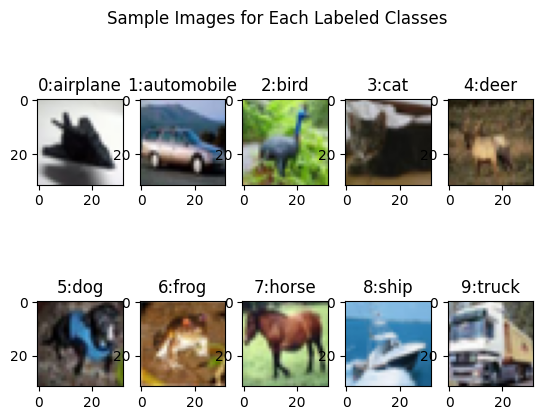

In [139]:
plotImages_Dataset(training_data, classLabel, nRows=2, nCols=5)

**07 -> Hyperparameters**

In [140]:
in_channels = 3
img_width   = 32
img_height  = 32
sequence_length = 32  # rowSize/sample_Size/Time_Steps -> !!(Max Sentence Length)!!
                      # For image processing, it is just "1"
hidden_size = 256     # LSTM unit has a hidden layer and its size define here
num_layers  = 1       # stacking LSTM_unit to LSTM_unit vertically (Depth of network, current lstm_unit is the next lstm_unit's input)
num_classes = 10
learning_rate = 1e-3 / 2
batch_size = 64
epochs = 15

**08 -> Prepare dataloader and print some basic info on each dataset**

In [141]:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

printInfo_DataLoader(train_dataloader, 'Training DataSet')
printInfo_DataLoader(valid_dataloader, 'Validating DataSet')

>>>  Training DataSet  <<<
Total Number of Samples: 50000
Total Number of Batches: 782
Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64
--------------------------------------------------
>>>  Validating DataSet  <<<
Total Number of Samples: 10000
Total Number of Batches: 157
Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64
--------------------------------------------------


**09 -> Setup Model and View Basic Layer Info**

In [142]:
model = Custom_CNN_LSTM(in_channels, img_width, img_height,
                 sequence_length, hidden_size, num_layers,  num_classes, device).to(device)
summary(model, (batch_size, in_channels, img_width, img_height))

Layer (type:depth-idx)                   Output Shape              Param #
Custom_CNN_LSTM                          [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 32, 32]          896
├─ReLU: 1-2                              [64, 32, 32, 32]          --
├─MaxPool2d: 1-3                         [64, 32, 15, 15]          --
├─Flatten: 1-4                           [64, 32, 225]             --
├─Dropout: 1-5                           [64, 32, 225]             --
├─LSTM: 1-6                              [64, 32, 256]             494,592
├─Dropout: 1-7                           [64, 256]                 --
├─Linear: 1-8                            [64, 256]                 65,792
├─Dropout: 1-9                           [64, 256]                 --
├─Linear: 1-10                           [64, 10]                  2,570
Total params: 563,850
Trainable params: 563,850
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.08
Input size (MB): 0.79
Forward/

**10 -> Loss function and optimizer setup**

In [143]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**11 -> Train model under n epochs**

In [144]:
epoch_metrics, best_valid_loss = train_model_under_n_epochs(train_dataloader,
                                                           valid_dataloader,
                                                           epochs,
                                                           model,
                                                           loss_fn,
                                                           optimizer,
                                                           device)

 >>> Model Training with 15 epochs <<<
epoch: 0
batch#: 000 batch_loss: 2.302232  [   64/50000]
batch#: 100 batch_loss: 1.825680  [ 6464/50000]
batch#: 200 batch_loss: 1.515806  [12864/50000]
batch#: 300 batch_loss: 1.631148  [19264/50000]
batch#: 400 batch_loss: 1.511726  [25664/50000]
batch#: 500 batch_loss: 1.642604  [32064/50000]
batch#: 600 batch_loss: 1.534178  [38464/50000]
batch#: 700 batch_loss: 1.453070  [44864/50000]
batch#: 781 batch_loss: 2.006761  [50000/50000]
epoch 0  -> training and validation results
train_loss: 1.65487, train_acc: 39.586%
valid_loss: 1.37668, valid_acc: 50.129%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch: 1
batch#: 000 batch_loss: 1.523942  [   64/50000]
batch#: 100 batch_loss: 1.230061  [ 6464/50000]
batch#: 200 batch_loss: 1.153715  [12864/50000]
batch#: 300 batch_loss: 1.438215  [19264/50000]
batch#: 400 batch_loss: 1.218436  [25664/50000]
batch#: 500 batch_loss: 1.448417  [32064/50000]
batch#: 600 batch_loss: 1.346372  [38464/50000]


**References:**


1.   https://www.youtube.com/watch?v=6QjPmgcsLLs
2.   https://www.youtube.com/watch?v=Gl2WXLIMvKA&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=5
3.   https://colah.github.io/posts/2015-08-Understanding-LSTMs/
4.   https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
5.   https://www.reddit.com/r/datascience/comments/17kmxnc/what_are_the_possible_reasons_for_validation_loss/









